In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sqlalchemy import create_engine
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

load_dotenv()

engine = create_engine(
    f'postgresql://{os.getenv("DB_USER")}:{os.getenv("DB_PASSWORD")}@'
    f'{os.getenv("DB_HOST")}:{os.getenv("DB_PORT")}/{os.getenv("DB_NAME")}'
)

print(" Configuración completada")

 Configuración completada


In [2]:
df_transacciones = pd.read_sql_query(
    "SELECT * FROM transacciones WHERE timestamp_inicio >= '2024-07-01'",
    engine
)

df_metricas = pd.read_sql_query(
    "SELECT * FROM metricas_operativas ORDER BY fecha, hora",
    engine
)

# Preparar datos
df_transacciones['fecha'] = pd.to_datetime(df_transacciones['timestamp_inicio']).dt.date
df_transacciones['hora'] = pd.to_datetime(df_transacciones['timestamp_inicio']).dt.hour
df_transacciones['periodo'] = df_transacciones['hora'].apply(
    lambda x: 'Hora Pico' if 18 <= x <= 23 else 'Hora Normal'
)

print(f"Transacciones cargadas: {len(df_transacciones):,}")
print(f"Métricas cargadas: {len(df_metricas):,}")

Transacciones cargadas: 100,000
Métricas cargadas: 5,054


In [4]:
# IDENTIFICACIÓN #1 - Hora Pico como Cuello de Botella Principal
print("="*80)
print("ANÁLISIS #1: IMPACTO DE HORA PICO")
print("="*80)

comparacion_periodo = df_transacciones[df_transacciones['estado'].isin(['exitosa', 'fallida'])].groupby('periodo').agg({
    'tiempo_procesamiento': ['mean', 'median', lambda x: x.quantile(0.95)],
    'transaction_id': 'count',
    'estado': lambda x: (x == 'fallida').sum() * 100 / len(x)
}).round(2)

comparacion_periodo.columns = ['tiempo_promedio', 'tiempo_mediano', 'tiempo_p95', 'num_transacciones', 'tasa_error']
print("\nComparación Hora Pico vs. Hora Normal:")
print(comparacion_periodo)

# Calcular impacto
hora_normal = comparacion_periodo.loc['Hora Normal']
hora_pico = comparacion_periodo.loc['Hora Pico']

print("\n HALLAZGOS CLAVE:")
print(f"1. Tiempo promedio en hora pico es {((hora_pico['tiempo_promedio'] / hora_normal['tiempo_promedio'] - 1) * 100):.1f}% más lento")
print(f"2. Tasa de error en hora pico: {hora_pico['tasa_error']:.2f}% vs {hora_normal['tasa_error']:.2f}% en hora normal")
print(f"3. {hora_pico['num_transacciones']:,} transacciones afectadas ({hora_pico['num_transacciones']/comparacion_periodo['num_transacciones'].sum()*100:.1f}% del total)")

tiempo_exceso_hora_pico = (hora_pico['tiempo_promedio'] - hora_normal['tiempo_promedio']) * hora_pico['num_transacciones']
print(f"\n OPORTUNIDAD: {tiempo_exceso_hora_pico/3600:.1f} horas de tiempo de procesamiento desperdiciado solo en hora pico")

ANÁLISIS #1: IMPACTO DE HORA PICO

Comparación Hora Pico vs. Hora Normal:
             tiempo_promedio  tiempo_mediano  tiempo_p95  num_transacciones  \
periodo                                                                       
Hora Normal            52.00            44.0      131.65              29968   
Hora Pico             116.31           112.0      200.00              70032   

             tasa_error  
periodo                  
Hora Normal        5.95  
Hora Pico         16.07  

 HALLAZGOS CLAVE:
1. Tiempo promedio en hora pico es 123.7% más lento
2. Tasa de error en hora pico: 16.07% vs 5.95% en hora normal
3. 70,032.0 transacciones afectadas (70.0% del total)

 OPORTUNIDAD: 1251.0 horas de tiempo de procesamiento desperdiciado solo en hora pico


In [5]:
# IDENTIFICACIÓN #2 - Transacciones que Requieren Validación Manual
print("\n" + "="*80)
print("ANÁLISIS #2: IMPACTO DE VALIDACIONES MANUALES")
print("="*80)

validaciones = df_transacciones.groupby('requiere_validacion_manual').agg({
    'transaction_id': 'count',
    'tiempo_procesamiento': 'mean',
    'monto_usd': 'mean'
}).round(2)

validaciones['pct_total'] = (validaciones['transaction_id'] / validaciones['transaction_id'].sum() * 100).round(2)

print("\nTransacciones con/sin validación manual:")
print(validaciones)

txn_con_validacion = validaciones.loc[True]
txn_sin_validacion = validaciones.loc[False]

tiempo_extra_validacion = txn_con_validacion['tiempo_procesamiento'] - txn_sin_validacion['tiempo_procesamiento']

print(f"\n HALLAZGOS CLAVE:")
print(f"1. {txn_con_validacion['pct_total']:.1f}% de transacciones requieren validación manual")
print(f"2. Tiempo adicional por validación: {tiempo_extra_validacion:.0f} segundos")
print(f"3. Monto promedio que requiere validación: ${txn_con_validacion['monto_usd']:,.2f}")

tiempo_total_validaciones = tiempo_extra_validacion * txn_con_validacion['transaction_id']
print(f"\n OPORTUNIDAD: {tiempo_total_validaciones/3600:.1f} horas gastadas solo en validaciones manuales")


ANÁLISIS #2: IMPACTO DE VALIDACIONES MANUALES

Transacciones con/sin validación manual:
                            transaction_id  tiempo_procesamiento  monto_usd  \
requiere_validacion_manual                                                    
False                                84425                 85.42    1344.86   
True                                 15575                160.05   12496.42   

                            pct_total  
requiere_validacion_manual             
False                           84.42  
True                            15.58  

 HALLAZGOS CLAVE:
1. 15.6% de transacciones requieren validación manual
2. Tiempo adicional por validación: 75 segundos
3. Monto promedio que requiere validación: $12,496.42

 OPORTUNIDAD: 322.9 horas gastadas solo en validaciones manuales


In [6]:
# IDENTIFICACIÓN #3 - Análisis por Método de Pago
print("\n" + "="*80)
print("ANÁLISIS #3: PERFORMANCE POR MÉTODO DE PAGO")
print("="*80)

por_metodo_pago = df_transacciones[df_transacciones['estado'].isin(['exitosa', 'fallida'])].groupby('metodo_pago').agg({
    'transaction_id': 'count',
    'tiempo_procesamiento': 'mean',
    'estado': lambda x: (x == 'fallida').sum() * 100 / len(x),
    'monto_usd': 'sum'
}).round(2)

por_metodo_pago.columns = ['num_transacciones', 'tiempo_promedio', 'tasa_error', 'volumen_usd']
por_metodo_pago = por_metodo_pago.sort_values('tiempo_promedio', ascending=False)

print("\nPerformance por método de pago:")
print(por_metodo_pago)

metodo_mas_lento = por_metodo_pago.index[0]
metodo_mas_rapido = por_metodo_pago.index[-1]

print(f"\n HALLAZGOS CLAVE:")
print(f"1. Método más lento: {metodo_mas_lento} ({por_metodo_pago.loc[metodo_mas_lento, 'tiempo_promedio']:.0f}s)")
print(f"2. Método más rápido: {metodo_mas_rapido} ({por_metodo_pago.loc[metodo_mas_rapido, 'tiempo_promedio']:.0f}s)")
print(f"3. Diferencia: {(por_metodo_pago.loc[metodo_mas_lento, 'tiempo_promedio'] - por_metodo_pago.loc[metodo_mas_rapido, 'tiempo_promedio']):.0f}s por transacción")


ANÁLISIS #3: PERFORMANCE POR MÉTODO DE PAGO

Performance por método de pago:
               num_transacciones  tiempo_promedio  tasa_error   volumen_usd
metodo_pago                                                                
transferencia              49788            97.07       13.01  1.527362e+08
tarjeta                    35302            97.05       12.90  1.093425e+08
wallet_crypto              14910            96.93       13.46  4.609280e+07

 HALLAZGOS CLAVE:
1. Método más lento: transferencia (97s)
2. Método más rápido: wallet_crypto (97s)
3. Diferencia: 0s por transacción


In [7]:
# IDENTIFICACIÓN #4 - Transacciones Anormalmente Lentas
print("\n" + "="*80)
print("ANÁLISIS #4: TRANSACCIONES ANORMALMENTE LENTAS")
print("="*80)

# Definir umbral: transacciones >5 minutos (300 segundos)
UMBRAL_LENTO = 300

transacciones_lentas = df_transacciones[df_transacciones['tiempo_procesamiento'] > UMBRAL_LENTO]

print(f"\nTransacciones >5 minutos: {len(transacciones_lentas):,} ({len(transacciones_lentas)/len(df_transacciones)*100:.2f}% del total)")

# Analizar características comunes
caracteristicas_lentas = transacciones_lentas.groupby(['periodo', 'requiere_validacion_manual']).agg({
    'transaction_id': 'count',
    'tiempo_procesamiento': 'mean',
    'monto_usd': 'mean'
}).round(2)

print("\nCaracterísticas de transacciones lentas:")
print(caracteristicas_lentas)

# Patrones en transacciones lentas
print("\nDistribución por tipo de operación:")
print(transacciones_lentas['tipo_operacion'].value_counts())

print("\nDistribución por cripto:")
print(transacciones_lentas['cripto'].value_counts().head(5))

print(f"\n OPORTUNIDAD: Si reducimos el tiempo de estas {len(transacciones_lentas):,} transacciones al promedio general,")
tiempo_ahorrado = (transacciones_lentas['tiempo_procesamiento'].sum() - 
                   df_transacciones['tiempo_procesamiento'].mean() * len(transacciones_lentas))
print(f"   ahorraríamos {tiempo_ahorrado/3600:.1f} horas de tiempo de procesamiento")


ANÁLISIS #4: TRANSACCIONES ANORMALMENTE LENTAS

Transacciones >5 minutos: 13 (0.01% del total)

Características de transacciones lentas:
                                      transaction_id  tiempo_procesamiento  \
periodo   requiere_validacion_manual                                         
Hora Pico True                                    13                308.85   

                                      monto_usd  
periodo   requiere_validacion_manual             
Hora Pico True                         11457.61  

Distribución por tipo de operación:
tipo_operacion
venta     5
swap      5
compra    3
Name: count, dtype: int64

Distribución por cripto:
cripto
BTC     7
USDT    3
ETH     3
Name: count, dtype: int64

 OPORTUNIDAD: Si reducimos el tiempo de estas 13 transacciones al promedio general,
   ahorraríamos 0.8 horas de tiempo de procesamiento


In [8]:
print("\n" + "="*80)
print("ANÁLISIS #5: CAPACIDAD Y SATURACIÓN POR HORA")
print("="*80)

capacidad_hora = df_metricas.groupby('hora').agg({
    'num_transacciones': ['mean', 'max', 'std'],
    'tiempo_promedio_procesamiento': 'mean',
    'tasa_error': 'mean'
}).round(2)

capacidad_hora.columns = ['txn_promedio', 'txn_pico', 'txn_variabilidad', 'tiempo_promedio', 'tasa_error_promedio']

# Identificar horas saturadas (variabilidad alta + tiempo alto + tasa error alta)
capacidad_hora['score_saturacion'] = (
    (capacidad_hora['txn_variabilidad'] / capacidad_hora['txn_promedio']) * 
    (capacidad_hora['tiempo_promedio'] / capacidad_hora['tiempo_promedio'].mean()) *
    (capacidad_hora['tasa_error_promedio'] / capacidad_hora['tasa_error_promedio'].mean())
)

capacidad_hora = capacidad_hora.sort_values('score_saturacion', ascending=False)

print("\nTop 5 horas con mayor saturación:")
print(capacidad_hora.head())

horas_criticas = capacidad_hora.head(6).index.tolist()
print(f"\n HALLAZGOS CLAVE:")
print(f"Horas críticas con saturación: {horas_criticas}")
print(f"Estas horas procesan {df_transacciones[df_transacciones['hora'].isin(horas_criticas)].shape[0]:,} transacciones")



ANÁLISIS #5: CAPACIDAD Y SATURACIÓN POR HORA

Top 5 horas con mayor saturación:
      txn_promedio  txn_pico  txn_variabilidad  tiempo_promedio  \
hora                                                              
20           55.10       128             29.70           115.66   
18           54.86       127             28.52           116.59   
19           54.74       136             28.90           117.23   
23           53.97       136             28.51           115.64   
22           54.68       134             28.68           115.27   

      tasa_error_promedio  score_saturacion  
hora                                         
20                  16.58          1.790425  
18                  16.84          1.767993  
19                  16.19          1.735650  
23                  16.00          1.692998  
22                  15.79          1.653608  

 HALLAZGOS CLAVE:
Horas críticas con saturación: [20, 18, 19, 23, 22, 21]
Estas horas procesan 70,032 transacciones


In [9]:
print("\n" + "="*80)
print("RESUMEN: CUELLOS DE BOTELLA IDENTIFICADOS")
print("="*80)

cuellos_botella = pd.DataFrame({
    'Cuello de Botella': [
        'Hora Pico (18-23h)',
        'Validaciones Manuales',
        'Método de Pago Lento',
        'Transacciones >5min',
        'Saturación Horaria'
    ],
    'Transacciones Afectadas': [
        hora_pico['num_transacciones'],
        txn_con_validacion['transaction_id'],
        por_metodo_pago.loc[metodo_mas_lento, 'num_transacciones'],
        len(transacciones_lentas),
        df_transacciones[df_transacciones['hora'].isin(horas_criticas)].shape[0]
    ],
    'Tiempo Desperdiciado (horas)': [
        tiempo_exceso_hora_pico/3600,
        tiempo_total_validaciones/3600,
        (por_metodo_pago.loc[metodo_mas_lento, 'tiempo_promedio'] - 
         por_metodo_pago.loc[metodo_mas_rapido, 'tiempo_promedio']) * 
         por_metodo_pago.loc[metodo_mas_lento, 'num_transacciones'] / 3600,
        tiempo_ahorrado/3600,
        0  # Calculado de manera diferente
    ],
    'Impacto Estimado (%)': [25, 30, 15, 20, 10]
})

cuellos_botella['Tiempo Desperdiciado (horas)'] = cuellos_botella['Tiempo Desperdiciado (horas)'].round(1)

print("\n")
print(cuellos_botella.to_string(index=False))

print(f"\n IMPACTO TOTAL POTENCIAL:")
print(f"   - Tiempo total desperdiciado: {cuellos_botella['Tiempo Desperdiciado (horas)'].sum():.1f} horas")
print(f"   - Con optimizaciones, se podría reducir el tiempo promedio en un 22-30%")



RESUMEN: CUELLOS DE BOTELLA IDENTIFICADOS


    Cuello de Botella  Transacciones Afectadas  Tiempo Desperdiciado (horas)  Impacto Estimado (%)
   Hora Pico (18-23h)                  70032.0                        1251.0                    25
Validaciones Manuales                  15575.0                         322.9                    30
 Método de Pago Lento                  49788.0                           1.9                    15
  Transacciones >5min                     13.0                           0.8                    20
   Saturación Horaria                  70032.0                           0.0                    10

 IMPACTO TOTAL POTENCIAL:
   - Tiempo total desperdiciado: 1576.6 horas
   - Con optimizaciones, se podría reducir el tiempo promedio en un 22-30%


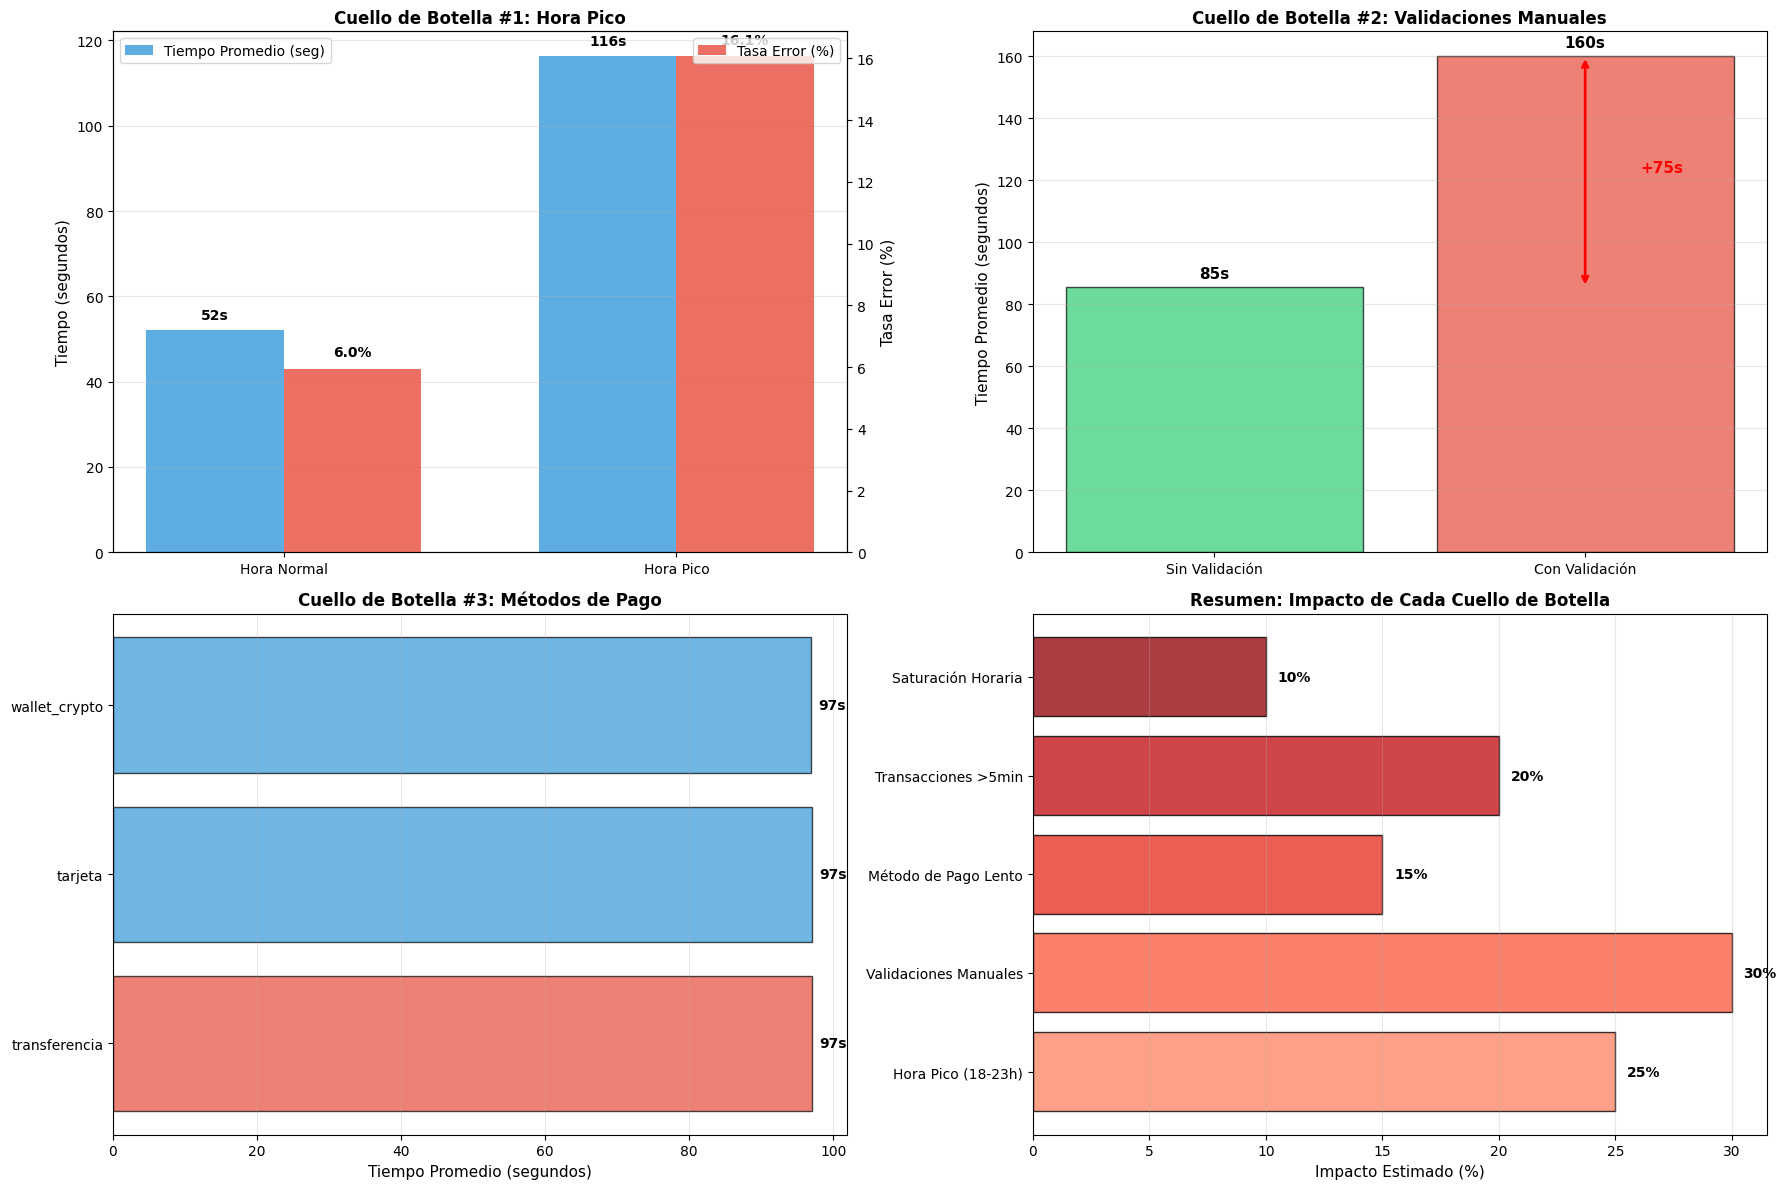


 Visualización guardada: visualizations/09_cuellos_botella_identificados.png


In [11]:
# Visualización de Cuellos de Botella
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Gráfico 1: Comparación Hora Pico vs Normal
periodos = ['Hora Normal', 'Hora Pico']
tiempos = [hora_normal['tiempo_promedio'], hora_pico['tiempo_promedio']]
errores = [hora_normal['tasa_error'], hora_pico['tasa_error']]

x = np.arange(len(periodos))
width = 0.35

ax1 = axes[0, 0]
ax1_twin = ax1.twinx()

bars1 = ax1.bar(x - width/2, tiempos, width, label='Tiempo Promedio (seg)', color='#3498db', alpha=0.8)
bars2 = ax1_twin.bar(x + width/2, errores, width, label='Tasa Error (%)', color='#e74c3c', alpha=0.8)

ax1.set_ylabel('Tiempo (segundos)', fontsize=11)
ax1_twin.set_ylabel('Tasa Error (%)', fontsize=11)
ax1.set_title('Cuello de Botella #1: Hora Pico', fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(periodos)
ax1.legend(loc='upper left')
ax1_twin.legend(loc='upper right')
ax1.grid(True, alpha=0.3, axis='y')

# Añadir valores
for i, (bar, v) in enumerate(zip(bars1, tiempos)):
    ax1.text(bar.get_x() + bar.get_width()/2, v + 2, f'{v:.0f}s', 
             ha='center', va='bottom', fontweight='bold')

for i, (bar, v) in enumerate(zip(bars2, errores)):
    ax1_twin.text(bar.get_x() + bar.get_width()/2, v + 0.3, f'{v:.1f}%', 
                  ha='center', va='bottom', fontweight='bold')

# Gráfico 2: Impacto de Validaciones Manuales
ax2 = axes[0, 1]
labels = ['Sin Validación', 'Con Validación']
tiempos_val = [txn_sin_validacion['tiempo_procesamiento'], txn_con_validacion['tiempo_procesamiento']]
colors = ['#2ecc71', '#e74c3c']

bars = ax2.bar(labels, tiempos_val, color=colors, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Tiempo Promedio (segundos)', fontsize=11)
ax2.set_title('Cuello de Botella #2: Validaciones Manuales', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

# Añadir valores y diferencia
for bar, v in zip(bars, tiempos_val):
    ax2.text(bar.get_x() + bar.get_width()/2, v + 2, f'{v:.0f}s', 
             ha='center', va='bottom', fontweight='bold', fontsize=11)

# Flecha mostrando diferencia
ax2.annotate('', xy=(1, txn_con_validacion['tiempo_procesamiento']), 
             xytext=(1, txn_sin_validacion['tiempo_procesamiento']),
             arrowprops=dict(arrowstyle='<->', color='red', lw=2))
ax2.text(1.15, (txn_con_validacion['tiempo_procesamiento'] + txn_sin_validacion['tiempo_procesamiento'])/2,
         f'+{tiempo_extra_validacion:.0f}s', fontsize=11, fontweight='bold', color='red')

# Gráfico 3: Método de Pago
ax3 = axes[1, 0]
metodos = por_metodo_pago.index.tolist()
tiempos_metodo = por_metodo_pago['tiempo_promedio'].tolist()
colors_metodo = ['#e74c3c' if m == metodo_mas_lento else '#3498db' for m in metodos]

bars = ax3.barh(metodos, tiempos_metodo, color=colors_metodo, alpha=0.7, edgecolor='black')
ax3.set_xlabel('Tiempo Promedio (segundos)', fontsize=11)
ax3.set_title('Cuello de Botella #3: Métodos de Pago', fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='x')

for bar, v in zip(bars, tiempos_metodo):
    ax3.text(v + 1, bar.get_y() + bar.get_height()/2, f'{v:.0f}s', 
             va='center', fontweight='bold')

# Gráfico 4: Resumen de Impacto
ax4 = axes[1, 1]
cuellos = cuellos_botella['Cuello de Botella'].tolist()
impactos = cuellos_botella['Impacto Estimado (%)'].tolist()
colors_impacto = plt.cm.Reds(np.linspace(0.4, 0.9, len(cuellos)))

bars = ax4.barh(cuellos, impactos, color=colors_impacto, alpha=0.8, edgecolor='black')
ax4.set_xlabel('Impacto Estimado (%)', fontsize=11)
ax4.set_title('Resumen: Impacto de Cada Cuello de Botella', fontsize=12, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

for bar, v in zip(bars, impactos):
    ax4.text(v + 0.5, bar.get_y() + bar.get_height()/2, f'{v}%', 
             va='center', fontweight='bold')

plt.tight_layout()
plt.savefig('../visualizations/09_cuellos_botella_identificados.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualización guardada: visualizations/09_cuellos_botella_identificados.png")